In [1]:
import numpy as np
from scipy import stats
from scipy.integrate import nquad

from matplotlib import pyplot as plt

from typing import Dict
from numpy import typing as npt
from sys import stderr

In [2]:
def read_chains(filename: str) -> Dict[str, npt.NDArray]:
    try:
        with open(filename, "r") as f:
            chains = dict()
            for line in f.readlines():
                name, *data = line.split()
                chains[name] = np.array(list(map(float, data)))
            return chains
    except IOError as e:
        print(f"{e}", file=stderr)
        return dict()

In [3]:
chains_without_hc = read_chains("../multidim_chen_no_hc.txt")
chains_with_hc = [read_chains("../multidim_chen_hc_0.txt"), read_chains("../multidim_chen_hc_1.txt")]

In [4]:
def avg_log_posterior(log_posterior):
    avg_lp = np.ndarray(shape=log_posterior.shape)
    avg_lp[0] = log_posterior[0]
    for i in range(1, avg_lp.shape[0]):
        avg_lp[i] = (avg_lp[i-1] * i + log_posterior[i]) / (i+1)
    return avg_lp

In [5]:
lp_without_hc = avg_log_posterior(chains_without_hc['log_posterior'])
lp_with_hc = [avg_log_posterior(chain['log_posterior']) for chain in chains_with_hc]

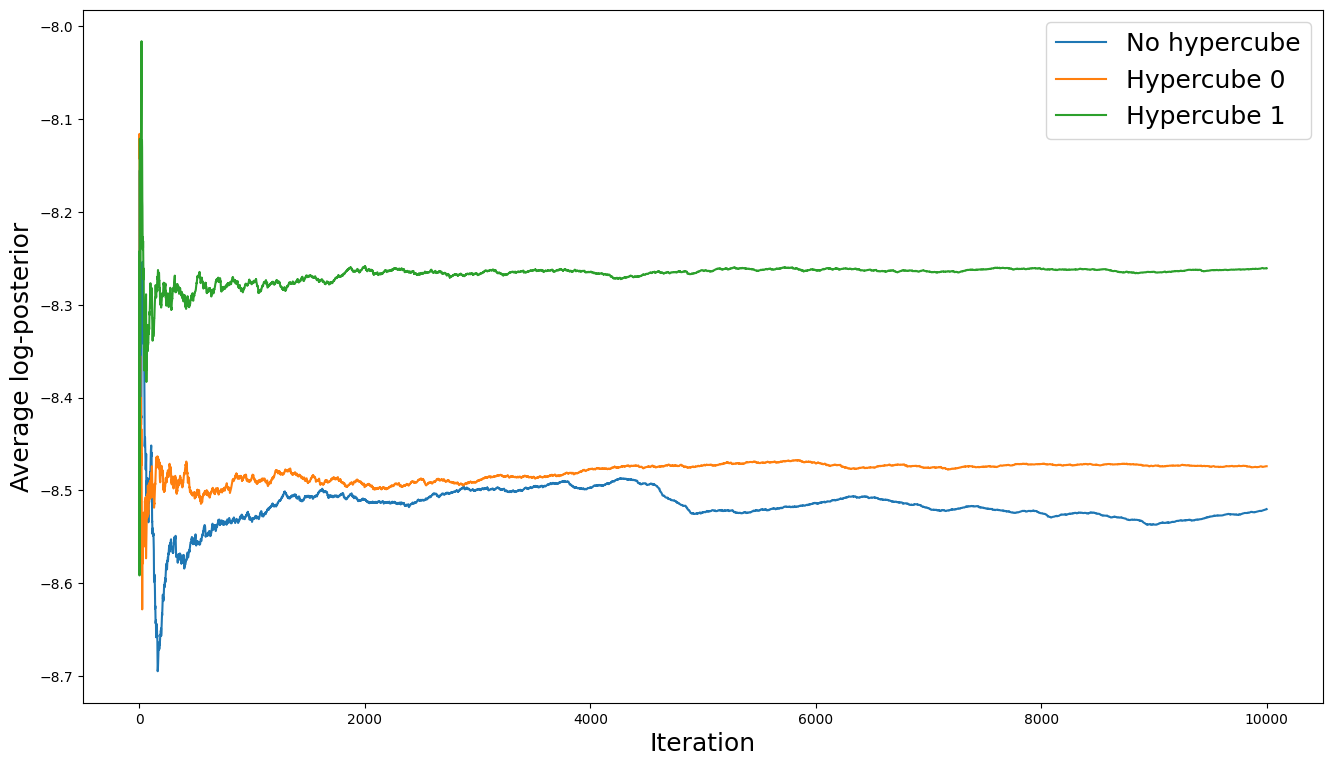

In [6]:
plt.figure(figsize=(16, 9))

plt.plot(range(lp_without_hc.shape[0]), lp_without_hc, marker="", label="No hypercube")
plt.plot(range(lp_with_hc[0].shape[0]), lp_with_hc[0], marker="", label="Hypercube 0")
plt.plot(range(lp_with_hc[1].shape[0]), lp_with_hc[1], marker="", label="Hypercube 1")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Average log-posterior", fontsize=18)
plt.legend(fontsize=18)

plt.show()

In [33]:
N = 1000
moving_avg_without_hc = np.convolve(chains_without_hc['log_posterior'], np.ones(N)/N, mode='valid')

moving_avg_with_hc = [np.convolve(chain['log_posterior'], np.ones(N)/N, mode='valid') for chain in chains_with_hc]

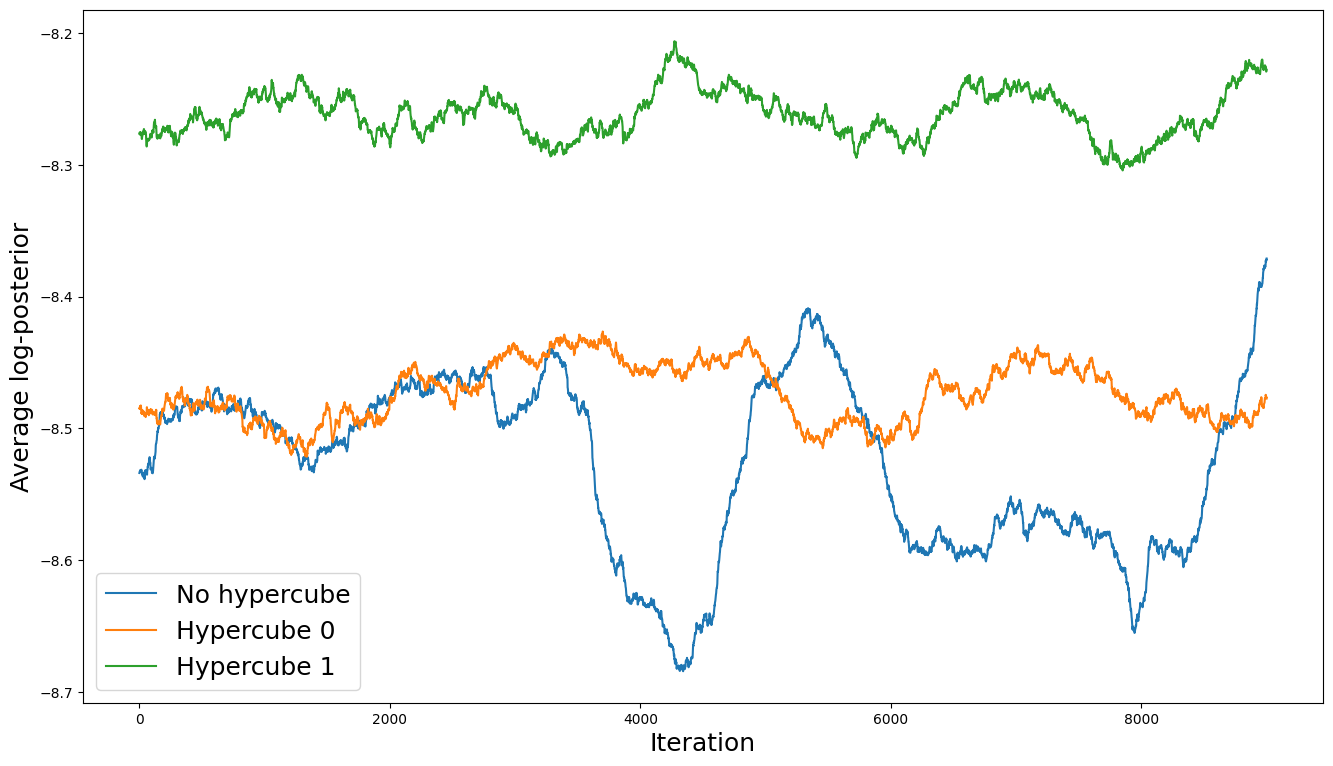

In [34]:
plt.figure(figsize=(16, 9))

plt.plot(range(moving_avg_without_hc.shape[0]), moving_avg_without_hc, label="No hypercube")
plt.plot(range(moving_avg_with_hc[0].shape[0]), moving_avg_with_hc[0], label="Hypercube 0")
plt.plot(range(moving_avg_with_hc[1].shape[0]), moving_avg_with_hc[1], label="Hypercube 1")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Average log-posterior", fontsize=18)
plt.legend(fontsize=18)

plt.show()

# Compare model

In [7]:
DIM = 5

In [8]:
orig_rho = [0.5, 0.45, 0.05]
assert sum(orig_rho) == 1.0

orig_mu = [0.0 * np.ones(shape=(DIM)), 0.75 * np.ones(shape=(DIM)), 3.0 * np.ones(shape=(DIM))]

orig_lambda = 0.1
orig_beta  = 0.001

orig_sigma = orig_lambda * np.eye(DIM, DIM) + orig_beta * (np.ones(shape=(DIM, DIM)) - np.eye(DIM, DIM))

def orig_model(x):
    return orig_rho[0] * stats.multivariate_normal.pdf(x, orig_mu[0], orig_sigma) + \
           orig_rho[1] * stats.multivariate_normal.pdf(x, orig_mu[1], orig_sigma) + \
           orig_rho[2] * stats.multivariate_normal.pdf(x, orig_mu[2], orig_sigma)

In [9]:
def param_model(x, theta):
    zero_mu = np.zeros(shape=(DIM))
    mu      = theta[1] * np.ones(shape=(DIM))
    sigma   = theta[2] * np.eye(DIM, DIM) + orig_beta * (np.ones(shape=(DIM, DIM)) - np.eye(DIM, DIM))

    return (1.0 - theta[0]) * stats.multivariate_normal.pdf(x, zero_mu, sigma) + \
           theta[0]         * stats.multivariate_normal.pdf(x, mu, sigma)